<ipython-input-6-65e4dd158098>:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')  # Forward-fill remaining missing values


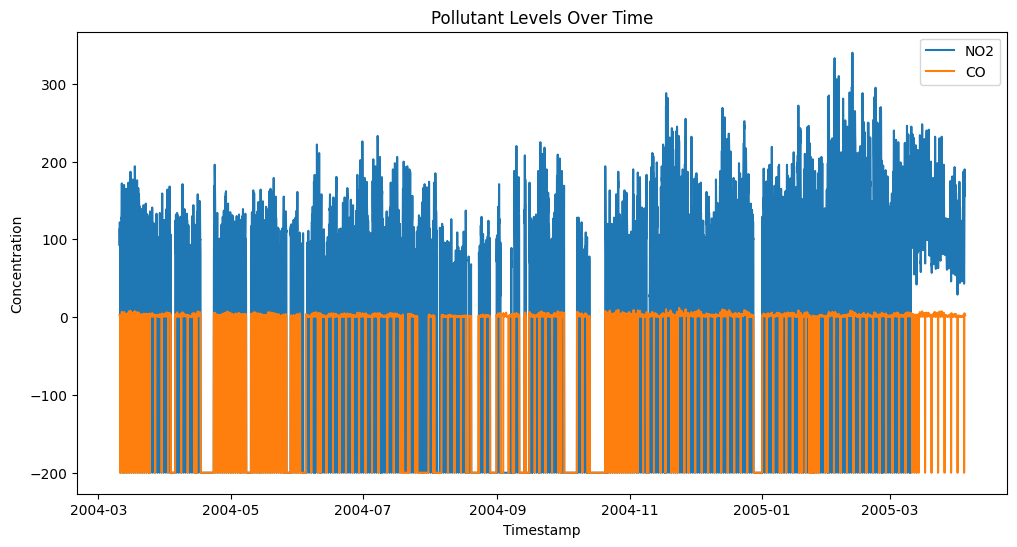

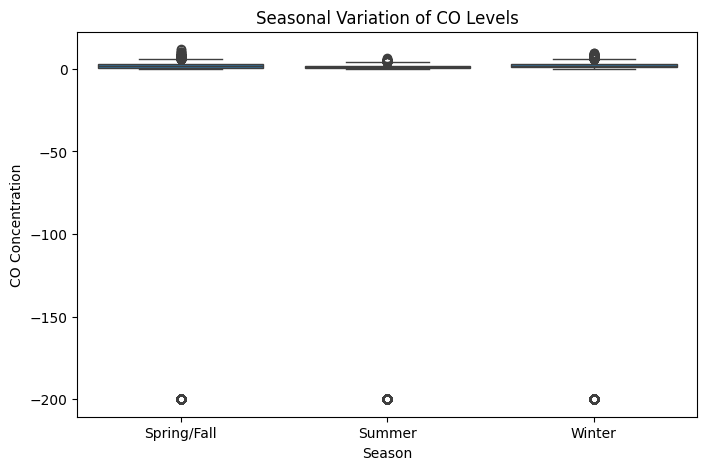

Random Forest RMSE: 33.54654762740793
Random Forest R^2: 0.809521353800877


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7136.3301
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5977.9390
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5698.3408
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5251.2339
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4411.4844
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3846.7349
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3428.6685
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3065.4978
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3287.9788
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3145.7944
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
LSTM RMSE: 52.59275735470219
LSTM R^2: 0.5318311516163938


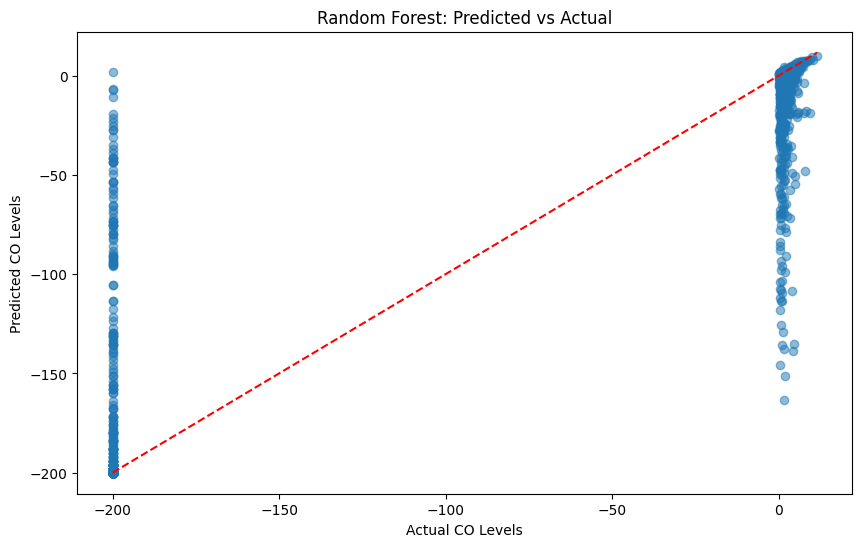

In [ ]:
# Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Step 1: Load the Dataset
data = pd.read_csv("/content/AirQuality (1).csv", delimiter=';')

# Step 2: Clean the Column Names
data.columns = data.columns.str.strip().str.replace(';', '').str.replace(' ', '_')

# Step 3: Drop Unnecessary Columns
data = data.drop(['Unnamed:_15', 'Unnamed:_16'], axis=1)

# Step 4: Convert Numeric Columns with Commas to Floats
for col in ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']:
    data[col] = data[col].str.replace(',', '.').astype(float)

# Step 5: Handle Missing Values
data = data.dropna(subset=['Date', 'Time'])  # Drop rows with missing Date or Time
data = data.fillna(method='ffill')  # Forward-fill remaining missing values

# Step 6: Create Timestamp and Extract Time-Based Features
data['timestamp'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H.%M.%S', errors='coerce')
data['hour'] = data['timestamp'].dt.hour
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['season'] = data['month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else 'Summer' if x in [6, 7, 8] else 'Spring/Fall')

# Step 7: Exploratory Data Analysis (EDA)
# Visualize pollutant trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='timestamp', y='NO2(GT)', label='NO2')
sns.lineplot(data=data, x='timestamp', y='CO(GT)', label='CO')
plt.title('Pollutant Levels Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Concentration')
plt.legend()
plt.show()

# Visualize seasonal variation
plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x='season', y='CO(GT)')
plt.title('Seasonal Variation of CO Levels')
plt.xlabel('Season')
plt.ylabel('CO Concentration')
plt.show()

# Step 8: Feature Engineering
# Selecting features and target for prediction
features = ['PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)',
            'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'hour', 'day', 'month']
target = 'CO(GT)'

# Step 9: Split Dataset into Train and Test Sets
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 10: Train Machine Learning Models
## Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
rf_predictions = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = r2_score(y_test, rf_predictions)
print(f"Random Forest RMSE: {rf_rmse}")
print(f"Random Forest R^2: {rf_r2}")

## LSTM Model
# Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train LSTM model
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=1)

# Predictions and evaluation
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
lstm_r2 = r2_score(y_test, lstm_predictions)
print(f"LSTM RMSE: {lstm_rmse}")
print(f"LSTM R^2: {lstm_r2}")

# Step 11: Visualization of Results
# Random Forest Prediction vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Random Forest: Predicted vs Actual')
plt.xlabel('Actual CO Levels')
plt.ylabel('Predicted CO Levels')
plt.show()

# Step 12: Save Results
data.to_csv('Cleaned_AirQuality_Data.csv', index=False)


In [ ]:
# Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Step 1: Load the Dataset
data = pd.read_csv("/content/AirQuality (1).csv", delimiter=';')

# Step 2: Clean the Column Names
data.columns = data.columns.str.strip().str.replace(';', '').str.replace(' ', '_')

# Step 3: Drop Unnecessary Columns
data = data.drop(['Unnamed:_15', 'Unnamed:_16'], axis=1)

# Step 4: Convert Numeric Columns with Commas to Floats
for col in ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']:
    data[col] = data[col].str.replace(',', '.').astype(float)

# Step 5: Handle Missing Values
data = data.dropna(subset=['Date', 'Time'])  # Drop rows with missing Date or Time
data = data.fillna(method='ffill')  # Forward-fill remaining missing values

# Step 6: Create Timestamp and Extract Time-Based Features
data['timestamp'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H.%M.%S', errors='coerce')
data['hour'] = data['timestamp'].dt.hour
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['season'] = data['month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else 'Summer' if x in [6, 7, 8] else 'Spring/Fall')

# Step 7: Feature Engineering
# Selecting features and target for prediction
features = ['PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)',
            'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'hour', 'day', 'month']
target = 'CO(GT)'

# Step 8: Split Dataset into Train and Test Sets
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 9: Train Machine Learning Models
## Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation for Random Forest
rf_predictions = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = r2_score(y_test, rf_predictions)
print(f"Random Forest RMSE: {rf_rmse}")
print(f"Random Forest R^2: {rf_r2}")

## LSTM Model
# Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train LSTM model
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=1)

# Predictions and evaluation for LSTM
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
lstm_r2 = r2_score(y_test, lstm_predictions)
print(f"LSTM RMSE: {lstm_rmse}")
print(f"LSTM R^2: {lstm_r2}")

# Step 10: Export Predictions to CSV for Tableau Visualization

# Create a DataFrame to store actual vs predicted values
predicted_values = pd.DataFrame({
    'Actual_CO(GT)': y_test,
    'Predicted_RF_CO(GT)': rf_predictions,
    'Predicted_LSTM_CO(GT)': lstm_predictions.flatten()  # Ensure it's 1D for consistency
})

# Save to a CSV file
predicted_values.to_csv('predicted_values.csv', index=False)

print("Predicted values exported to 'predicted_values.csv'")


<ipython-input-8-14e48a90c53a>:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')  # Forward-fill remaining missing values


Random Forest RMSE: 33.54654762740793
Random Forest R^2: 0.809521353800877
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7362.0718
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6406.1875
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5399.1597
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4941.7485
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4277.8135
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3657.5356
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3435.2822
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3302.8838
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3170.7739
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3278.5068
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
LSTM RMSE: 53.08042424678442
LSTM R^2: 0.5231086976397799
Predicted values exported to 'predicted_values.csv'
